In [1]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
from transformers import CLIPModel, CLIPProcessor
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import glob
import os 
from PIL import Image
import cv2
import torch.nn.functional as F
import torch.nn as nn 
from torchvision.models import resnet50, ResNet50_Weights
import torch.optim as optim
import tqdm
from torch.optim import lr_scheduler

import matplotlib.cm as cm 
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import heapq
from collections import defaultdict
import wandb
from torch.utils.data import Sampler
import copy


/home/moonlab/Reid/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_seed(seed):
    """320
    This function is used to set the seed for reproducibility
    
    Attributes: Seed: An integer value to set the seed
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seed(42)

# Setting the seed is important as whenever we will re-run the notebook we will get the same results

In [3]:
class config:
    """
    This class defines the configuration that are required for the training.\n
    Attributes:\n device: Device to be used for training (cuda or cpu)\n
                train_image_dir: Directory path for training images
                query_image_dir: Directory path for query images
                gallery_image_dir: Directory path for gallery images
                model: Model name to be used
                image_size: Size of the input images
                batch_size: Batch size for training
                num_workers: Number of workers for data loading
                learning_rate: Learning rate for optimizer
                epochs: Number of epochs for training
                num_classes: Number of classes in the dataset
                feat_dim: Dimension of the feature vector
                clip_dim: Dimension of the CLIP feature vector

    """
    def __init__(self)->None:
    

        self.device : str = "cuda" if torch.cuda.is_available() else "cpu"

        self.train_image_dir : str = "/home/moonlab/Reid/data/VeRi/image_train"
        self.query_image_dir : str = "/home/moonlab/Reid/data/VeRi/image_query"
        self.gallery_image_dir : str = "/home/moonlab/Reid/data/VeRi/image_test"

        self.clip_model_name : str = "openai/clip-vit-base-patch32"
        self.image_size : tuple = (256, 256)
        self.batch_size : int = 64
        self.num_workers : int = 4
        self.learning_rate : float = 25e-4
        self.epochs : int = 96


        self.num_classes : int = 576
        self.feat_dim : int = 2048
        self.clip_dim : int =512


        # Lets add the sampling constraints 
        self.num_instances : int = 8
        self.num_pids_per_instance : int = 8

cfg : config =config()
print("Device used:",cfg.device)

Device used: cuda


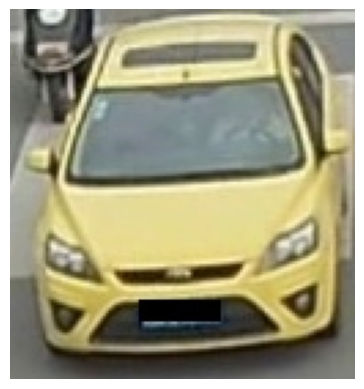

In [4]:
# Lets visualize the image that you have.
image_path1 : str = "/home/moonlab/Reid/data/VeRi/image_train/0001_c001_00016450_0.jpg"
if image_path1 is not None:
    image : np.ndarray = cv2.imread(image_path1)
    plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    plt.axis("off")

In [5]:
class CarlaVeriDataset(Dataset):
    """
    This class inherits from the torch Dataset class and helps creating the batches of dataset as per requirement
    
    This is the custom class to load the Vehcile Reidentification dataset.\
    This class handles the infamous vehicle reidentification dataset called the Veri- 776
    TODO : Explain the input and output, add the attributes of the class
    """


    def __init__(self, dir_path: str, transform : T.Compose)-> None:
        self.image_dir : str = dir_path
        self.transform : T.Compose = transform

        self.image_paths= glob.glob(os.path.join(self.image_dir, "*.jpg"))
        self. image_paths =sorted(self.image_paths)

        if self.image_paths is None:
            print("There are no images in the directory")


        self.pids: list =[]
        self.camids: list = []
        self.valid_paths : list =[]


        for image_path in self.image_paths:
            file_name: str = os.path.basename(image_path).replace(".jpg","")
            parts=file_name.split("_")


            if len(parts)>=2:
                pid: int = int(parts[0])
                if parts[1].startswith("c"):
                    camid: int =int(parts[1][1:])
                else:
                    camid: int = int(parts[1])

                self.pids.append(pid)
                self.camids.append(camid)
                self.valid_paths.append(image_path)

        self.image_path=self.valid_paths


        """NOTE: 
            
            As you can see in the dataset that the first part of parts is the vehicle ID and the second part of parts is the camera id starting with C.
            Since it is starting with C so the if else that we have written above, makes sure that if the part 2 starts with C then we skip that C and take the values after that and if it doesn't start with C then we take the value of the part2 directly

        
        """
        self.unique_pids : list = sorted(list(set(self.pids)))
        self.pid_maps: dict ={old:new for new, old in enumerate(self.unique_pids)}
        self.new_pids : list = [self.pid_maps[p] for p in self.pids]


        print(f"Total_ images: {len(self.image_path)}, Total unique pids : {len(self.unique_pids)}")


    def __len__(self)->int:
        return len(self.image_path)
        

    def __getitem__(self,index:int)-> tuple:
        path: str =self.image_path[index]
        camid: int =self.camids[index]
        pid : int =self.new_pids[index]
        original_pid : int = self.pids[index]

        image = cv2.imread(path)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image=Image.fromarray(image)
        if self.transform is not None:
            image = self.transform(image)

        return image, pid, camid, original_pid, path


            




        


In [6]:
## lets define the transforms for the dataset
train_transforms=T.Compose([
    T.Resize((256,256)),
    T.RandomHorizontalFlip(),
    T.Pad(10),
    T.RandomCrop(256,256),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

## lets execute the verification on the train dataset
train_directory=cfg.train_image_dir
train_dataset=CarlaVeriDataset(dir_path=train_directory, transform=train_transforms)

Total_ images: 37778, Total unique pids : 576


In [7]:
train_dataset[0]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [8]:
class RandomIdentitySampler(Sampler):
    """
    This RandomIdentitySampler class inherits from the torch.Sampler class

    Randomly samples N identities from the dataset
    And for each of those N identitie, randomly samples K instances of that identity.
    Hence the batch size will be N*K

    As in our dataset the batch size is 32.
    So In every batch we are sampling 8 different identities
    For each identity we are randomly sampling 4 instances.

    TODO: Explain the input , output and the attributes of the class
    """

    def __init__(self, dataset: Dataset, batch_size: int =32, num_instances: int =4,):
        self.dataset: Dataset= dataset
        self.batch_size : int = batch_size
        self.num_instances : int = num_instances
        self.num_pids_per_batch: int = self.batch_size // self.num_instances
        self.index_dic : dict =defaultdict(list)

        for index, pid in enumerate(self.dataset.new_pids):
            self.index_dic[pid].append(index)

            """ NOTE: Understanding the above snippet. 
                    We have created a default dict so that the we can directly add the keys and values even for the keys that are not yet defined.
                    for each key we are having the value as a list
                    """
            
            self.pids=list(self.index_dic.keys())


            self.length : int =0
            for pid in self.pids:
                idxs=self.index_dic[pid]
                num=len(idxs)
                if num < self.num_instances:
                    num =self.num_instances
                self.length += num - num % self.num_instances
            



    def __iter__(self):
        batch_idxs_dict : dict = defaultdict(list)
        for pid in self.pids:
            idxs : list = copy.deepcopy(self.index_dic[pid])
            if len(idxs)< self.num_instances:
                idxs =np.random.choice(idxs, size =(self.num_instances), replace= True)
            random.shuffle(idxs)
            batch_idxs_dict[pid]=idxs
        avai_pids : list =copy.deepcopy(self.pids)
        final_idxs : list =[]

        while len(avai_pids)>= self.num_pids_per_batch:
            selected_pids : list =random.sample(avai_pids, self.num_pids_per_batch)
            for pid in selected_pids:
                batch_idxs: list = batch_idxs_dict[pid][:self.num_instances]
                batch_idxs_dict[pid]=batch_idxs_dict[pid][self.num_instances:]
                if len(batch_idxs_dict[pid])< self.num_instances:
                    avai_pids.remove(pid)

                final_idxs.extend(batch_idxs)
        return iter(final_idxs)

    def __len__(self):
        return self.length





In [9]:
class IBN(nn.Module):
    """
    This class implements the Instance-Batch Normalization Layer. 
    NOTE:" Why Instance-Batch Normalization Layer?
    The ResNet that we are implementing here is not the standard ResNet,
    But a modified ResNet with IBN layers.

    Standard ResNet uses Batch Normalization that normalizes the features across the entire batch.
    Instance Normalization normalizes the features for each instance in the batch seperately.


    IN IBN, the feature channels are split into two parts: one part undersgoes Instance Normalization, while the other part goes to the Batch Normalization.
    """

    def __init__(self,planes:int)-> None:
        """In this class we pass the number of feature planes as input"""
        super(IBN,self).__init__()
        half1=int(planes/2)
        half2=planes-half1

        self.IN =nn.InstanceNorm2d(half1,affine=True)
        self.BN=nn.BatchNorm2d(half2)


            
    def forward(self,x:torch.Tensor)-> torch.Tensor:
        """This function defines the forward pass of the IBN Layer"""
        split_size = x.size(1) // 2
        split=torch.split(x, split_size,1)

        out1=self.IN(split[0].contiguous())
        out2=self.BN(split[1].contiguous())


        out=torch.cat((out1,out2),1)
        return out


In [10]:
class BottleneckIBN(nn.Module):
    """This class defines how or convolution layers should be looking but including the Instance Batch Normalization BottleNeck"""
    expansion=4
    def __init__(self, inplanes, planes, strides=1, downsample=None):
        super(BottleneckIBN,self).__init__()

        self.conv1=nn.Conv2d(in_channels=inplanes,out_channels=planes,kernel_size=1,bias=False)
        self.bn1=IBN(planes)

        self.conv2=nn.Conv2d(in_channels=planes, out_channels=planes, padding=1, kernel_size=3, stride=strides, bias=False)
        self.bn2=nn.BatchNorm2d(planes)

        self.conv3=nn.Conv2d(in_channels=planes, out_channels=planes*self.expansion,kernel_size=1, bias=False)
        self.bn3=nn.BatchNorm2d(planes*self.expansion)

        self.relu=nn.ReLU(inplace=True)

        self.downsample=downsample
        self.strides=strides


    def forward(self,x: torch.Tensor)-> torch.Tensor:
        identity=x
        out=self.conv1(x)
        out=self.bn1(out)
        out=self.relu(out)

        out=self.conv2(out)
        out=self.bn2(out)
        out=self.relu(out)

        out=self.conv3(out)
        out=self.bn3(out)

        if self.downsample is not None:
            identity=self.downsample(x)

        out+=identity
        out=self.relu(out)

        return out

        

    


In [11]:
class ResNetIBN(torch.nn.Module):
    """In this module we will define the ResNet50 architecture as the feature extractor"""
    def __init__(self,config):
        super(ResNetIBN,self).__init__()
        self.model=resnet50(weights=ResNet50_Weights.DEFAULT)
        layer1_layers=[]

        layer1_layers.append(BottleneckIBN(64,64,strides=1,downsample=self.model.layer1[0].downsample))
        layer1_layers.append(BottleneckIBN(256,64,strides=1))
        layer1_layers.append(BottleneckIBN(256,64,strides=1))


        self.model.layer1=nn.Sequential(*layer1_layers)
        self.model.avgpool=nn.AdaptiveAvgPool2d((1,1))
        self.model.fc=nn.Identity()

        self.model.out_dim=2048


    def forward(self,x):
        features=self.model(x)
        return features
        

        


In [12]:
class SemanticExtractionModule(nn.Module):
    """
    This class defines the semantic extraction module  using the ClipVector
    Here we input the image tensor and get the CLS token as the semantic vector representation of the image.
    Here the pooler output that we are taking is the CLS token representation of the image. 
    """
    def __init__(self,config):
        super(SemanticExtractionModule,self).__init__()
        self.clip=CLIPModel.from_pretrained(config.clip_model_name)

        self.vision_model = self.clip.vision_model
        
        # 2. The Projection Layer (Maps 768 -> 512 dim)
        self.visual_projection = self.clip.visual_projection
        
        # Freeze everything to save memory/compute
        for param in self.vision_model.parameters():
            param.requires_grad = False
        for param in self.visual_projection.parameters():
            param.requires_grad = False
        self.output_dim=config.clip_dim


    def forward(self,x:torch.Tensor)-> torch.Tensor:
        vision_outputs=self.vision_model(pixel_values=x,interpolate_pos_encoding=True)
        semantic_features=vision_outputs.pooler_output
        semantic_features = self.visual_projection(semantic_features)

        return semantic_features

In [13]:
class FusionModule(nn.Module):
    """This class is the fusion module that fuses the features that we get from the ResNetIBN and the semantic extraction module"""
    def __init__(self,config):
        super(FusionModule,self).__init__()

        self.feat_dim=config.feat_dim
        self.clip_dim=config.clip_dim


        self.dim_reduce=nn.Sequential(
            nn.Linear(in_features=self.feat_dim+self.clip_dim,out_features=self.feat_dim,bias=False),
            nn.BatchNorm1d(self.feat_dim),
            nn.ReLU(inplace=True))
        


    def forward(self, visual_features:torch.Tensor, semantic_features:torch.Tensor)-> torch.Tensor:
        f1=visual_features.view(visual_features.size(0),-1)
        f2=semantic_features.view(semantic_features.size(0),-1)

        fused_features=torch.cat((f1,f2),dim=1)
        fused_features=self.dim_reduce(fused_features)
        return fused_features
        
        

In [14]:
class AFEMModule(torch.nn.Module):
    """
    This class defines the Adaptive Feature Enhancement Module as discussed in the paper 

    """

    def __init__(self, in_dim,out_dim, groups):
        super(AFEMModule,self).__init__()

        self.groups=groups
        self.in_dim=in_dim

        self.f_linear=nn.Sequential(
            nn.Linear(in_dim,out_dim),
            nn.BatchNorm1d(out_dim),
            nn.ReLU(inplace=True)
        )

        """
        The 512 dimensional feature vector that we got from the clip image encoding we are passing it that to the semantic feature enhancement module module.
        where the vectors are first past through a linear MLP, Batch Normalization and ReLU activation function.
        Then since we have decided that the number of groups that we have is 32 so based on the semantic vector dimension we will divide the semantic vector into the respective groups and

        """

        ## Lets define the parameter weights

        self.W = nn.Parameter(torch.tensor(torch.zeros(1, groups) + 1e-3))


    def forward(self,t_s):
        x=self.f_linear(t_s)

        batch,dim=x.shape
        channels_per_group= dim//self.groups
        """Here we are dividing the the features into groups"""

        x_grouped=x.view(batch,self.groups,channels_per_group)
        expanded_weights=self.W.view(1, self.groups, 1)
        weighted_groups=x_grouped*expanded_weights

        weighted_out=weighted_groups.view(batch,dim)

        ts_prime=x+weighted_out

        return ts_prime

        

In [15]:
class CLIP_SENet(nn.Module):
    """This class is defined so that  whatever we have build till now we can use that up."""
    
    def __init__(self,config)->None:
        super(CLIP_SENet,self).__init__()

        # Lets call the apprearence backbone
        self.backbone=ResNetIBN(config)
        self.gap=nn.AdaptiveAvgPool2d(1)

        # Lets call the semantic module

        self.sem_module=SemanticExtractionModule(config)
        self.sem_bn=nn.BatchNorm1d(config.clip_dim)

        self.afem=AFEMModule(in_dim=config.clip_dim, out_dim=config.feat_dim,groups=32)

        self.fusion_module=FusionModule(config=config)

        self.bottleneck=nn.BatchNorm1d(config.feat_dim)
        self.classifier=nn.Linear(in_features=config.feat_dim, out_features=cfg.num_classes,bias=False)

        self.identity_loss=nn.CrossEntropyLoss()
        self.trip_loss=nn.TripletMarginLoss(margin=0.3)


    def forward(self,images:torch.tensor,labels):
        """Here the input is the iamge of B,C,H,W and the batch of the ground truth of the labels """
        ta=self.backbone(images)
        ts=self.sem_module(images)
        ts=self.sem_bn(ts)

        ts_prime=self.afem(ts)

        fusion=self.fusion_module(ta,ts)

        t=ts_prime + fusion

        feat_norm=self.bottleneck(t)
        logits=self.classifier(t)

        


        return t,logits



        



In [16]:
class LossWrapper(nn.Module):
    def __init__(self,num_classes,epsilon=0.1, temperature=0.07):
        super(LossWrapper,self).__init__()

        self.ce_loss=nn.CrossEntropyLoss(label_smoothing=epsilon)
        self.temperature=temperature


    def supercon_loss(self,features,labels):
        """In the supercontrastive loss we push the positive and negative pairs apart and pull close the positive pair"""
        device=cfg.device
        batch_size=features.shape[0]

        features= F.normalize(features,dim=1)

        similarity_matrix=torch.matmul(features,features.T)

        labels=labels.contiguous().view(-1,1)
        mask=torch.eq(labels,labels.T).float().to(device)
        logit_masks=torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size).view(-1,1).to(device),
            0
        )
        mask=mask*logit_masks
        logits=similarity_matrix / self.temperature

        logits_max,_=torch.max(logits,dim=1,keepdim=True)
        logits=logits-logits_max.detach()


        exp_logits=torch.exp(logits)*logit_masks
        log_prob=logits-torch.log(exp_logits.sum(1,keepdim=True)+1e-12)

        mask_pos_pairs = mask.sum(1)
        
        # Avoid division by zero: 
        # If an anchor has no positives, set divisor to 1 (loss becomes 0 for that sample)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, torch.ones_like(mask_pos_pairs), mask_pos_pairs)

        mean_log_prob_pos=(mask*log_prob).sum(1) / mask_pos_pairs
        loss=-mean_log_prob_pos.mean()


        return loss
    
    def forward(self,cls_score,features,targets):
        ce_loss=self.ce_loss(cls_score,targets)
        sc_loss=self.supercon_loss(features,targets)
        total_loss= ce_loss+sc_loss

        return total_loss,ce_loss,sc_loss
    

    



        
    

In [17]:

# def train():
#     # --- 0. WANDB INIT ---
#     # Initialize the run. We pass the config so hyperparameters are saved.
#     wandb.init(
#         project="CLIP_SENet_ReID", 
#         name="PxK_Training_256x256",
#         config={
#             "image_size": 256,
#             "batch_size": cfg.batch_size,
#             "epochs": cfg.epochs,
#             "learning_rate": 5e-4,
#             "weight_decay": 5e-4,
#             "P": cfg.num_pids_per_instance,
#             "K": cfg.num_instances
#         }
#     )

#     # --- 1. CONFIGURATION & TRANSFORMS ---
#     train_transforms = T.Compose([
#         T.Resize((256, 256)),
#         T.RandomHorizontalFlip(),
#         T.Pad(10),
#         T.RandomCrop(256, 256),
#         T.ToTensor(),
#         T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     ])
#     print(f"Transformations set to 256x256. Loading Data...")

#     train_dataset = CarlaVeriDataset(dir_path=cfg.train_image_dir, transform=train_transforms)
#     cfg.num_classes = len(train_dataset.unique_pids)
    
#     custom_sampler = RandomIdentitySampler(train_dataset, cfg.batch_size, cfg.num_instances)
    
#     train_loader = DataLoader(
#         train_dataset, 
#         batch_size=cfg.batch_size, 
#         sampler=custom_sampler,
#         num_workers=cfg.num_workers,
#         pin_memory=True
#     )

#     print(f"Dataset Loaded! P={cfg.num_pids_per_instance}, K={cfg.num_instances}")
    
#     model = CLIP_SENet(cfg).to(cfg.device)
#     criterion = LossWrapper(num_classes=cfg.num_classes).to(cfg.device)

#     # --- WANDB WATCH ---
#     # This automatically logs gradients and model topology
#     wandb.watch(model, log="all", log_freq=100)

#     # --- 2. GRADIENT SAFETY CHECK ---
#     print("Model Initialization done! Doing the Gradients Safety Check")
#     trainable_params = 0
#     frozen_params = 0

#     for name, param in model.named_parameters():
#         if param.requires_grad:
#             trainable_params += param.numel()
#         else:
#             frozen_params += param.numel()

#     print(f"Trainable Params: {trainable_params}")
#     print(f"Frozen Params:    {frozen_params}")

#     if frozen_params == 0:
#         print("⚠️ Warning! The CLIP encoder is not frozen. Recheck if this is intended.")
#     else:
#         print("✅ Gradient Check Passed: CLIP Encoder is frozen.")

#     # --- 3. OPTIMIZER & SCHEDULER ---
#     optimizer = torch.optim.Adam(
#         model.parameters(), 
#         lr=5e-4,
#         weight_decay=5e-4
#     )
    
#     scheduler = lr_scheduler.CosineAnnealingLR(
#         optimizer, 
#         T_max=cfg.epochs, 
#         eta_min=1e-6
#     )

#     # --- 4. TRAINING LOOP ---
#     print(f"\nStarting Training for {cfg.epochs} epochs...")
#     model.train()

#     for epoch in range(cfg.epochs):
#         total_loss = 0.0
#         total_ce = 0.0
#         total_sc = 0.0
#         num_batches = 0
        
#         current_lr = optimizer.param_groups[0]['lr']
#         loop = tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{cfg.epochs} [LR={current_lr:.6f}]")
        
#         for images, labels, camids, original_pids, paths in loop:
#             images = images.to(cfg.device)
#             labels = labels.to(cfg.device)

#             optimizer.zero_grad()

#             # Forward Pass
#             features, logits = model(images, labels)
            
#             if torch.isnan(features).any():
#                 print("❌ NaN detected in Features! Skipping Batch.")
#                 continue

#             # Loss Calculation
#             loss, ce, sc = criterion(logits, features, labels)

#             # Backward Pass
#             loss.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
#             optimizer.step()
            
#             # Metrics
#             total_loss += loss.item()
#             total_ce += ce.item()
#             total_sc += sc.item()
#             num_batches += 1
            
#             # --- WANDB LOGGING (Batch Level) ---
#             wandb.log({
#                 "batch_loss": loss.item(),
#                 "batch_ce_loss": ce.item(),
#                 "batch_sc_loss": sc.item(),
#                 "learning_rate": current_lr
#             })
            
#             loop.set_postfix(loss=f"{loss.item():.4f}", ce=f"{ce.item():.4f}", sc=f"{sc.item():.4f}")

#         # --- END OF EPOCH ---
#         scheduler.step()
        
#         avg_loss = total_loss / num_batches if num_batches > 0 else 0
#         avg_ce = total_ce / num_batches if num_batches > 0 else 0
#         avg_sc = total_sc / num_batches if num_batches > 0 else 0
        
#         # --- WANDB LOGGING (Epoch Level) ---
#         wandb.log({
#             "epoch": epoch + 1,
#             "epoch_loss": avg_loss,
#             "epoch_ce_loss": avg_ce,
#             "epoch_sc_loss": avg_sc
#         })
        
#         print(f"\nEpoch [{epoch+1}/{cfg.epochs}] Summary:")
#         print(f"  Avg Total Loss: {avg_loss:.4f}")
#         print(f"  Avg CE Loss:    {avg_ce:.4f}")
#         print(f"  Avg SC Loss:    {avg_sc:.4f}")
#         print("-" * 30)
        
#         if (epoch + 1) % 5 == 0:
#             torch.save(model.state_dict(), f"latest_model_epoch_{epoch+1}.pth")

#     # Final Save
#     torch.save(model.state_dict(), "latest_model2.pth")
    
#     # --- WANDB FINISH ---
#     wandb.save("latest_model2.pth") # Upload model to cloud
#     wandb.finish()
    
#     print("Training Complete. Model Saved.")

# if __name__ == "__main__":
#     train()

In [19]:
import torch
import torch.nn.functional as F
import tqdm
import numpy as np
import wandb
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
from torch.optim import lr_scheduler
import gc

# --- 1. VALIDATION HELPER FUNCTION (FIXED) ---
def validate(model, query_loader, gallery_loader, device):
    """
    Runs inference on Query and Gallery, computes mAP and Rank-1.
    """
    model.eval()
    
    # --- A. Extract Features ---
    def get_features(loader):
        feats, pids, camids = [], [], []
        with torch.no_grad():
            for imgs, pid, camid, _, _ in loader:
                imgs = imgs.to(device)
                
                # Mixed Precision Inference (Matches Training)
                with autocast():
                    # Pass dummy labels as your forward() expects them
                    f, _ = model(imgs, torch.zeros(imgs.size(0)).long().to(device))
                    f = F.normalize(f, p=2, dim=1) # Normalize for Cosine Sim
                
                feats.append(f.cpu())
                pids.append(pid)
                camids.append(camid)
        return torch.cat(feats), torch.cat(pids), torch.cat(camids)

    print("  [Validation] Extracting Query Features...")
    q_feats, q_pids, q_camids = get_features(query_loader)
    print("  [Validation] Extracting Gallery Features...")
    g_feats, g_pids, g_camids = get_features(gallery_loader)

    # --- B. Compute Metrics ---
    print("  [Validation] Computing Metrics...")
    # Cosine Similarity
    dist_mat = torch.mm(q_feats, g_feats.t()).numpy()
    
    # --- FIX APPLIED HERE: Added .copy() to fix negative stride error ---
    index = np.argsort(dist_mat, axis=1)[:, ::-1].copy()

    all_ap = []
    cmc_hits = np.zeros(10) # For Rank-1 to Rank-10

    # Loop through queries
    for q_idx in range(len(q_pids)):
        q_pid = q_pids[q_idx]
        q_camid = q_camids[q_idx]

        order = index[q_idx]
        pid_matches = (g_pids[order] == q_pid).numpy()
        cam_matches = (g_camids[order] == q_camid).numpy()

        # Remove Junk (Same ID, Same Camera)
        valid_mask = ~(pid_matches & cam_matches)
        pid_matches = pid_matches[valid_mask]
        
        # Calculate AP
        good_index = np.argwhere(pid_matches).flatten()
        if len(good_index) == 0: 
            all_ap.append(0)
            continue
            
        cmc_hits[good_index[0]:] += 1 # Update CMC
        
        # AP Calculation
        num_good = len(good_index)
        rows_good_cumsum = pid_matches.cumsum()
        precision = rows_good_cumsum[good_index] / (good_index + 1)
        all_ap.append(precision.sum() / num_good)

    mAP = np.mean(all_ap)
    cmc = cmc_hits / len(q_pids)
    
    return mAP, cmc[0], cmc[4], cmc[9] # mAP, R1, R5, R10

# --- 2. MAIN TRAINING LOOP (FULL) ---
def train_with_validation():
    # CONFIGURATION
    PHYSICAL_BATCH = 64
    ACCUM_STEPS = 4 # Effective Batch 128
    
    cfg.batch_size = PHYSICAL_BATCH
    cfg.epochs = 96 # Increased to ensure convergence with large effective batch
    
    # Initialize WandB
    # Add try-except to handle re-init issues safely
    try:
        wandb.init(project="CLIP_SENet_ReID", name="Train_Val_Fixed", reinit=True)
    except:
        print("WandB re-init skipped or failed, continuing...")

    # --- LOADERS ---
    # Training Transform (Augmentation)
    train_transform = T.Compose([
        T.Resize((320, 320)),
        T.RandomHorizontalFlip(),
        T.Pad(10), T.RandomCrop(320, 320),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Validation Transform (No Augmentation)
    val_transform = T.Compose([
        T.Resize((320, 320)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Datasets
    train_ds = CarlaVeriDataset(cfg.train_image_dir, transform=train_transform)
    query_ds = CarlaVeriDataset(cfg.query_image_dir, transform=val_transform)
    gallery_ds = CarlaVeriDataset(cfg.gallery_image_dir, transform=val_transform)

    # Sampler for Training (K=4 is Safer for unbalanced datasets)
    sampler = RandomIdentitySampler(train_ds, cfg.batch_size, num_instances=8)

    train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, sampler=sampler, num_workers=4, pin_memory=True)
    
    # Validation Loaders (Reduced to 32 to prevent Memory Crashes)
    query_loader = DataLoader(query_ds, batch_size=64, shuffle=False, num_workers=4)
    gallery_loader = DataLoader(gallery_ds, batch_size=64, shuffle=False, num_workers=4)

    # Model & Optimizer
    model = CLIP_SENet(cfg).to(cfg.device)
    optimizer = torch.optim.Adam(model.parameters(), lr=25e-4, weight_decay=5e-4)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.epochs, eta_min=1e-6)
    criterion = LossWrapper(num_classes=len(train_ds.unique_pids)).to(cfg.device)
    
    # Gradient Scaler
    scaler = GradScaler()

    best_map = 0.0

    print(f"Starting Training: Epochs={cfg.epochs}, Eff. Batch=128 (Phys={PHYSICAL_BATCH}x{ACCUM_STEPS})")
    
    for epoch in range(cfg.epochs):
        # --- TRAIN ---
        model.train()
        loop = tqdm.tqdm(train_loader, desc=f"Ep {epoch+1}/{cfg.epochs}")
        optimizer.zero_grad()
        
        train_loss = 0
        
        for i, (imgs, lbls, _, _, _) in enumerate(loop):
            imgs, lbls = imgs.to(cfg.device), lbls.to(cfg.device)
            
            with autocast():
                feats, logits = model(imgs, lbls)
                loss, _, _ = criterion(logits, feats, lbls)
                loss = loss / ACCUM_STEPS # Normalize loss for accumulation
            
            scaler.scale(loss).backward()
            
            # Step every ACCUM_STEPS
            if (i + 1) % ACCUM_STEPS == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 10.0)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            
            train_loss += loss.item() * ACCUM_STEPS
            loop.set_postfix(loss=f"{loss.item()*ACCUM_STEPS:.4f}")

        scheduler.step()
        
        # --- VALIDATE (End of Epoch) ---
        # Explicit Memory Cleanup to prevent "Connection Lost" errors
        torch.cuda.empty_cache()
        gc.collect()

        print(f"\nEnd of Epoch {epoch+1}. Running Validation...")
        mAP, r1, r5, r10 = validate(model, query_loader, gallery_loader, cfg.device)
        
        print(f"  [RESULT] mAP: {mAP:.2%} | Rank-1: {r1:.2%} | Rank-5: {r5:.2%}")
        
        # Logging
        wandb.log({
            "epoch": epoch+1,
            "train_loss": train_loss / len(train_loader),
            "val_mAP": mAP,
            "val_Rank1": r1,
            "val_Rank5": r5,
            "lr": optimizer.param_groups[0]['lr']
        })

        # Save Best Model
        if mAP > best_map:
            best_map = mAP
            torch.save(model.state_dict(), "best_model_mAP.pth")
            print(f"  >>> New Best mAP! Model Saved.")
        
        # Periodic checkpoint
        if (epoch + 1) % 10 == 0:
             torch.save(model.state_dict(), f"checkpoint_epoch_{epoch+1}.pth")

    print(f"Training Complete. Best mAP: {best_map:.2%}")

if __name__ == "__main__":
    train_with_validation()

wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Total_ images: 37778, Total unique pids : 576
Total_ images: 1678, Total unique pids : 200
Total_ images: 11579, Total unique pids : 200


/tmp/ipykernel_956792/274845811.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.W = nn.Parameter(torch.tensor(torch.zeros(1, groups) + 1e-3))
/tmp/ipykernel_956792/17707747.py:139: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Starting Training: Epochs=96, Eff. Batch=128 (Phys=64x4)


Ep 1/96:   0%|          | 0/561 [00:00<?, ?it/s]/tmp/ipykernel_956792/17707747.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Ep 1/96:  99%|█████████▉| 555/561 [02:58<00:01,  3.12it/s, loss=8.0213] 



End of Epoch 1. Running Validation...
  [Validation] Extracting Query Features...


/tmp/ipykernel_956792/17707747.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 8.49% | Rank-1: 25.98% | Rank-5: 42.49%
  >>> New Best mAP! Model Saved.


Ep 2/96:  99%|█████████▉| 554/561 [02:57<00:02,  3.12it/s, loss=7.1181] 



End of Epoch 2. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 16.09% | Rank-1: 37.25% | Rank-5: 58.22%
  >>> New Best mAP! Model Saved.


Ep 3/96:  99%|█████████▉| 555/561 [02:45<00:01,  3.35it/s, loss=7.4994] 



End of Epoch 3. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 15.38% | Rank-1: 37.43% | Rank-5: 56.79%


Ep 4/96:  99%|█████████▉| 555/561 [02:45<00:01,  3.35it/s, loss=7.8678] 



End of Epoch 4. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 17.14% | Rank-1: 39.09% | Rank-5: 60.55%
  >>> New Best mAP! Model Saved.


Ep 5/96:  99%|█████████▉| 556/561 [02:45<00:01,  3.35it/s, loss=7.6641] 



End of Epoch 5. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 13.28% | Rank-1: 33.91% | Rank-5: 54.05%


Ep 6/96:  99%|█████████▉| 557/561 [02:46<00:01,  3.35it/s, loss=7.4564] 



End of Epoch 6. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 17.30% | Rank-1: 38.97% | Rank-5: 59.65%
  >>> New Best mAP! Model Saved.


Ep 7/96:  99%|█████████▉| 556/561 [02:45<00:01,  3.35it/s, loss=7.2628] 



End of Epoch 7. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 12.75% | Rank-1: 34.68% | Rank-5: 56.44%


Ep 8/96:  99%|█████████▉| 557/561 [02:46<00:01,  3.35it/s, loss=7.5772] 



End of Epoch 8. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 16.31% | Rank-1: 38.74% | Rank-5: 58.70%


Ep 9/96:  99%|█████████▉| 555/561 [02:45<00:01,  3.35it/s, loss=7.6008] 



End of Epoch 9. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 17.88% | Rank-1: 39.57% | Rank-5: 59.95%
  >>> New Best mAP! Model Saved.


Ep 10/96:  98%|█████████▊| 551/561 [02:44<00:02,  3.36it/s, loss=7.2016] 



End of Epoch 10. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 18.43% | Rank-1: 39.69% | Rank-5: 61.38%
  >>> New Best mAP! Model Saved.


Ep 11/96:  99%|█████████▉| 556/561 [02:45<00:01,  3.35it/s, loss=7.8966] 



End of Epoch 11. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 18.16% | Rank-1: 41.00% | Rank-5: 61.98%


Ep 12/96:  99%|█████████▉| 558/561 [02:59<00:00,  3.11it/s, loss=7.5624] 



End of Epoch 12. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 18.22% | Rank-1: 39.51% | Rank-5: 60.07%


Ep 13/96:  99%|█████████▉| 556/561 [02:58<00:01,  3.11it/s, loss=6.5881] 



End of Epoch 13. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 18.47% | Rank-1: 39.99% | Rank-5: 61.56%
  >>> New Best mAP! Model Saved.


Ep 14/96:  99%|█████████▉| 556/561 [02:45<00:01,  3.36it/s, loss=7.6302] 



End of Epoch 14. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 18.77% | Rank-1: 40.94% | Rank-5: 62.22%
  >>> New Best mAP! Model Saved.


Ep 15/96:  99%|█████████▊| 553/561 [02:44<00:02,  3.36it/s, loss=7.6304] 



End of Epoch 15. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 18.98% | Rank-1: 41.84% | Rank-5: 62.10%
  >>> New Best mAP! Model Saved.


Ep 16/96:  98%|█████████▊| 552/561 [02:53<00:02,  3.18it/s, loss=7.5925] 



End of Epoch 16. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 18.81% | Rank-1: 41.95% | Rank-5: 62.46%


Ep 17/96:  99%|█████████▉| 555/561 [02:59<00:01,  3.10it/s, loss=7.0212] 



End of Epoch 17. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 18.89% | Rank-1: 41.30% | Rank-5: 62.69%


Ep 18/96:  99%|█████████▉| 557/561 [03:00<00:01,  3.08it/s, loss=7.7109] 



End of Epoch 18. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 19.28% | Rank-1: 41.30% | Rank-5: 61.86%
  >>> New Best mAP! Model Saved.


Ep 19/96:  99%|█████████▉| 556/561 [03:05<00:01,  3.00it/s, loss=7.8616] 



End of Epoch 19. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 19.52% | Rank-1: 42.25% | Rank-5: 62.87%
  >>> New Best mAP! Model Saved.


Ep 20/96:  99%|█████████▉| 555/561 [02:58<00:01,  3.11it/s, loss=7.3818] 



End of Epoch 20. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 19.02% | Rank-1: 42.01% | Rank-5: 63.11%


Ep 21/96:  99%|█████████▉| 557/561 [03:00<00:01,  3.08it/s, loss=7.1449] 



End of Epoch 21. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 19.43% | Rank-1: 41.72% | Rank-5: 63.23%


Ep 22/96:  99%|█████████▉| 555/561 [02:58<00:01,  3.11it/s, loss=7.7388] 



End of Epoch 22. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 19.35% | Rank-1: 42.43% | Rank-5: 63.71%


Ep 23/96:  99%|█████████▉| 556/561 [03:01<00:01,  3.07it/s, loss=7.7793] 



End of Epoch 23. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 19.60% | Rank-1: 41.60% | Rank-5: 63.89%
  >>> New Best mAP! Model Saved.


Ep 24/96:  99%|█████████▉| 555/561 [03:03<00:01,  3.03it/s, loss=7.4277] 



End of Epoch 24. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 19.65% | Rank-1: 42.37% | Rank-5: 62.81%
  >>> New Best mAP! Model Saved.


Ep 25/96:  99%|█████████▉| 556/561 [03:01<00:01,  3.06it/s, loss=7.9279] 



End of Epoch 25. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 19.86% | Rank-1: 41.60% | Rank-5: 63.17%
  >>> New Best mAP! Model Saved.


Ep 26/96:  99%|█████████▉| 556/561 [03:01<00:01,  3.07it/s, loss=7.4917] 



End of Epoch 26. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 19.82% | Rank-1: 42.43% | Rank-5: 62.93%


Ep 27/96:  99%|█████████▉| 557/561 [02:59<00:01,  3.10it/s, loss=7.1280] 



End of Epoch 27. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 19.66% | Rank-1: 42.85% | Rank-5: 64.60%


Ep 28/96:  99%|█████████▊| 553/561 [02:56<00:02,  3.13it/s, loss=7.6923] 



End of Epoch 28. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 20.13% | Rank-1: 42.97% | Rank-5: 65.14%
  >>> New Best mAP! Model Saved.


Ep 29/96:  99%|█████████▉| 555/561 [02:56<00:01,  3.14it/s, loss=7.3642] 



End of Epoch 29. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 20.06% | Rank-1: 43.03% | Rank-5: 65.02%


Ep 30/96:  99%|█████████▉| 554/561 [03:01<00:02,  3.05it/s, loss=7.3707] 



End of Epoch 30. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 20.26% | Rank-1: 43.98% | Rank-5: 64.96%
  >>> New Best mAP! Model Saved.


Ep 31/96:  99%|█████████▉| 555/561 [02:58<00:01,  3.11it/s, loss=7.6673] 



End of Epoch 31. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 20.24% | Rank-1: 42.07% | Rank-5: 64.84%


Ep 32/96:  99%|█████████▉| 557/561 [02:58<00:01,  3.12it/s, loss=7.1604] 



End of Epoch 32. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 20.26% | Rank-1: 43.15% | Rank-5: 64.96%
  >>> New Best mAP! Model Saved.


Ep 33/96:  99%|█████████▉| 554/561 [02:58<00:02,  3.11it/s, loss=7.7277] 



End of Epoch 33. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 20.13% | Rank-1: 42.25% | Rank-5: 64.60%


Ep 34/96:  99%|█████████▉| 554/561 [02:42<00:02,  3.40it/s, loss=7.6369] 



End of Epoch 34. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 20.85% | Rank-1: 44.28% | Rank-5: 65.61%
  >>> New Best mAP! Model Saved.


Ep 35/96:  99%|█████████▉| 558/561 [02:44<00:00,  3.39it/s, loss=7.3277] 



End of Epoch 35. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 20.19% | Rank-1: 43.27% | Rank-5: 65.02%


Ep 36/96:  99%|█████████▉| 555/561 [02:43<00:01,  3.40it/s, loss=7.4372] 



End of Epoch 36. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 20.44% | Rank-1: 43.38% | Rank-5: 65.79%


Ep 37/96:  99%|█████████▉| 554/561 [02:42<00:02,  3.41it/s, loss=7.4977] 



End of Epoch 37. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 20.42% | Rank-1: 44.10% | Rank-5: 67.04%


Ep 38/96:  99%|█████████▉| 556/561 [02:43<00:01,  3.41it/s, loss=7.2761] 



End of Epoch 38. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 20.12% | Rank-1: 41.90% | Rank-5: 65.38%


Ep 39/96:  99%|█████████▉| 555/561 [02:42<00:01,  3.41it/s, loss=7.7310] 



End of Epoch 39. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 20.57% | Rank-1: 45.23% | Rank-5: 65.55%


Ep 40/96:  99%|█████████▉| 555/561 [02:42<00:01,  3.41it/s, loss=7.3206] 



End of Epoch 40. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 20.67% | Rank-1: 44.10% | Rank-5: 65.32%


Ep 41/96:  99%|█████████▉| 556/561 [02:43<00:01,  3.40it/s, loss=7.3789] 



End of Epoch 41. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 20.69% | Rank-1: 43.33% | Rank-5: 65.55%


Ep 42/96:  98%|█████████▊| 552/561 [02:42<00:02,  3.41it/s, loss=8.0603] 



End of Epoch 42. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 20.66% | Rank-1: 43.44% | Rank-5: 65.44%


Ep 43/96:  99%|█████████▊| 553/561 [02:42<00:02,  3.41it/s, loss=7.1166] 



End of Epoch 43. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 20.82% | Rank-1: 42.79% | Rank-5: 65.49%


Ep 44/96:  99%|█████████▉| 555/561 [02:42<00:01,  3.41it/s, loss=6.8284] 



End of Epoch 44. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 20.55% | Rank-1: 44.16% | Rank-5: 66.03%


Ep 45/96:  99%|█████████▉| 557/561 [02:43<00:01,  3.41it/s, loss=7.5293] 



End of Epoch 45. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 20.71% | Rank-1: 45.17% | Rank-5: 65.20%


Ep 46/96:  99%|█████████▉| 554/561 [02:42<00:02,  3.41it/s, loss=7.5816] 



End of Epoch 46. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 20.78% | Rank-1: 46.19% | Rank-5: 66.45%


Ep 47/96:  99%|█████████▉| 557/561 [02:43<00:01,  3.41it/s, loss=7.0164] 



End of Epoch 47. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 20.72% | Rank-1: 45.95% | Rank-5: 66.39%


Ep 48/96:  99%|█████████▉| 555/561 [02:42<00:01,  3.41it/s, loss=8.2154] 



End of Epoch 48. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 21.28% | Rank-1: 44.40% | Rank-5: 67.46%
  >>> New Best mAP! Model Saved.


Ep 49/96:  98%|█████████▊| 552/561 [02:42<00:02,  3.40it/s, loss=7.5281] 



End of Epoch 49. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 21.16% | Rank-1: 46.25% | Rank-5: 66.69%


Ep 50/96:  99%|█████████▉| 554/561 [02:42<00:02,  3.41it/s, loss=7.2448] 



End of Epoch 50. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 21.23% | Rank-1: 45.29% | Rank-5: 66.57%


Ep 51/96:  99%|█████████▉| 556/561 [02:43<00:01,  3.41it/s, loss=7.3277] 



End of Epoch 51. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 21.07% | Rank-1: 45.23% | Rank-5: 65.91%


Ep 52/96:  99%|█████████▉| 555/561 [02:42<00:01,  3.41it/s, loss=7.5017] 



End of Epoch 52. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 21.11% | Rank-1: 46.19% | Rank-5: 66.33%


Ep 53/96:  99%|█████████▉| 556/561 [02:42<00:01,  3.41it/s, loss=7.6939] 



End of Epoch 53. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 21.05% | Rank-1: 45.59% | Rank-5: 65.20%


Ep 54/96:  99%|█████████▉| 554/561 [02:42<00:02,  3.41it/s, loss=7.6922] 



End of Epoch 54. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 21.43% | Rank-1: 44.99% | Rank-5: 66.98%
  >>> New Best mAP! Model Saved.


Ep 55/96:  99%|█████████▉| 556/561 [02:53<00:01,  3.21it/s, loss=7.4757]



End of Epoch 55. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 21.15% | Rank-1: 45.95% | Rank-5: 66.03%


Ep 56/96:  99%|█████████▉| 556/561 [02:56<00:01,  3.15it/s, loss=7.3795] 



End of Epoch 56. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 21.15% | Rank-1: 45.35% | Rank-5: 66.63%


Ep 57/96:  99%|█████████▉| 557/561 [02:54<00:01,  3.19it/s, loss=7.1800]



End of Epoch 57. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 21.51% | Rank-1: 45.83% | Rank-5: 66.75%
  >>> New Best mAP! Model Saved.


Ep 58/96:  99%|█████████▉| 557/561 [02:56<00:01,  3.15it/s, loss=7.4606]



End of Epoch 58. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 21.51% | Rank-1: 45.89% | Rank-5: 66.92%
  >>> New Best mAP! Model Saved.


Ep 59/96:  99%|█████████▉| 555/561 [02:56<00:01,  3.15it/s, loss=8.1532] 



End of Epoch 59. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 21.42% | Rank-1: 46.36% | Rank-5: 66.45%


Ep 60/96:  99%|█████████▉| 554/561 [02:54<00:02,  3.18it/s, loss=6.8380]



End of Epoch 60. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 21.53% | Rank-1: 45.95% | Rank-5: 67.70%
  >>> New Best mAP! Model Saved.


Ep 61/96:  99%|█████████▉| 557/561 [02:57<00:01,  3.14it/s, loss=7.8844] 



End of Epoch 61. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 21.54% | Rank-1: 46.78% | Rank-5: 66.75%
  >>> New Best mAP! Model Saved.


Ep 62/96:  99%|█████████▉| 555/561 [02:54<00:01,  3.17it/s, loss=7.8370] 



End of Epoch 62. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 21.59% | Rank-1: 45.83% | Rank-5: 66.75%
  >>> New Best mAP! Model Saved.


Ep 63/96:  99%|█████████▉| 556/561 [02:44<00:01,  3.38it/s, loss=7.4549]



End of Epoch 63. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 21.95% | Rank-1: 47.14% | Rank-5: 66.81%
  >>> New Best mAP! Model Saved.


Ep 64/96:  99%|█████████▉| 555/561 [02:42<00:01,  3.42it/s, loss=7.9489]



End of Epoch 64. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 21.75% | Rank-1: 46.84% | Rank-5: 66.45%


Ep 65/96:  99%|█████████▊| 553/561 [02:41<00:02,  3.42it/s, loss=7.2222] 



End of Epoch 65. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 21.57% | Rank-1: 45.89% | Rank-5: 66.81%


Ep 66/96:  99%|█████████▉| 554/561 [02:41<00:02,  3.42it/s, loss=7.6930]



End of Epoch 66. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 22.24% | Rank-1: 46.96% | Rank-5: 67.64%
  >>> New Best mAP! Model Saved.


Ep 67/96:  99%|█████████▉| 557/561 [02:42<00:01,  3.42it/s, loss=7.1460]



End of Epoch 67. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 21.96% | Rank-1: 46.66% | Rank-5: 66.98%


Ep 68/96:  98%|█████████▊| 552/561 [02:41<00:02,  3.42it/s, loss=7.2547] 



End of Epoch 68. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 21.99% | Rank-1: 46.19% | Rank-5: 67.52%


Ep 69/96:  99%|█████████▉| 556/561 [02:42<00:01,  3.42it/s, loss=7.4694] 



End of Epoch 69. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 21.85% | Rank-1: 46.31% | Rank-5: 66.63%


Ep 70/96:  99%|█████████▉| 555/561 [02:42<00:01,  3.42it/s, loss=7.2666]



End of Epoch 70. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 21.83% | Rank-1: 47.44% | Rank-5: 67.94%


Ep 71/96:  99%|█████████▉| 557/561 [02:42<00:01,  3.42it/s, loss=7.0926]



End of Epoch 71. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 21.89% | Rank-1: 46.96% | Rank-5: 67.82%


Ep 72/96:  99%|█████████▉| 557/561 [02:42<00:01,  3.42it/s, loss=7.5295]



End of Epoch 72. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 22.08% | Rank-1: 46.78% | Rank-5: 67.34%


Ep 73/96:  99%|█████████▊| 553/561 [02:41<00:02,  3.42it/s, loss=7.4731]



End of Epoch 73. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 21.83% | Rank-1: 45.29% | Rank-5: 66.75%


Ep 74/96:  99%|█████████▉| 554/561 [02:42<00:02,  3.42it/s, loss=7.4044] 



End of Epoch 74. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 22.07% | Rank-1: 46.13% | Rank-5: 67.52%


Ep 75/96:  99%|█████████▉| 557/561 [02:43<00:01,  3.41it/s, loss=7.1962]



End of Epoch 75. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 21.75% | Rank-1: 46.36% | Rank-5: 66.98%


Ep 76/96:  99%|█████████▉| 555/561 [02:42<00:01,  3.42it/s, loss=7.5305]



End of Epoch 76. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 21.94% | Rank-1: 47.79% | Rank-5: 66.33%


Ep 77/96:  99%|█████████▉| 556/561 [02:42<00:01,  3.41it/s, loss=6.8038]



End of Epoch 77. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 22.12% | Rank-1: 47.50% | Rank-5: 66.92%


Ep 78/96:  99%|█████████▉| 555/561 [02:42<00:01,  3.42it/s, loss=7.4540]



End of Epoch 78. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 21.99% | Rank-1: 46.90% | Rank-5: 66.57%


Ep 79/96:  99%|█████████▉| 556/561 [02:42<00:01,  3.42it/s, loss=7.5270]



End of Epoch 79. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 21.96% | Rank-1: 47.20% | Rank-5: 67.10%


Ep 80/96:  99%|█████████▉| 554/561 [02:41<00:02,  3.42it/s, loss=6.7982]



End of Epoch 80. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 22.10% | Rank-1: 46.13% | Rank-5: 67.64%


Ep 81/96:  99%|█████████▉| 556/561 [02:42<00:01,  3.42it/s, loss=6.9178]



End of Epoch 81. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 21.90% | Rank-1: 45.71% | Rank-5: 66.69%


Ep 82/96:  99%|█████████▉| 555/561 [02:42<00:01,  3.42it/s, loss=7.4066]



End of Epoch 82. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 21.67% | Rank-1: 46.42% | Rank-5: 66.57%


Ep 83/96:  99%|█████████▉| 556/561 [02:42<00:01,  3.42it/s, loss=7.3249]



End of Epoch 83. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 21.89% | Rank-1: 46.72% | Rank-5: 67.28%


Ep 84/96:  99%|█████████▊| 553/561 [02:41<00:02,  3.42it/s, loss=7.4476]



End of Epoch 84. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 22.25% | Rank-1: 46.78% | Rank-5: 67.28%
  >>> New Best mAP! Model Saved.


Ep 85/96:  99%|█████████▉| 558/561 [02:43<00:00,  3.42it/s, loss=7.4260]



End of Epoch 85. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 22.17% | Rank-1: 47.08% | Rank-5: 67.10%


Ep 86/96:  99%|█████████▉| 554/561 [02:41<00:02,  3.42it/s, loss=7.5018]



End of Epoch 86. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 22.23% | Rank-1: 47.26% | Rank-5: 66.87%


Ep 87/96:  99%|█████████▉| 554/561 [02:41<00:02,  3.42it/s, loss=8.0268]



End of Epoch 87. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 22.21% | Rank-1: 47.32% | Rank-5: 67.52%


Ep 88/96:  99%|█████████▉| 555/561 [02:42<00:01,  3.42it/s, loss=7.3443]



End of Epoch 88. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 22.05% | Rank-1: 46.78% | Rank-5: 66.92%


Ep 89/96:  99%|█████████▉| 554/561 [02:41<00:02,  3.43it/s, loss=7.2980]



End of Epoch 89. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 22.14% | Rank-1: 46.84% | Rank-5: 67.34%


Ep 90/96:  99%|█████████▉| 557/561 [02:42<00:01,  3.43it/s, loss=7.0282]



End of Epoch 90. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 22.16% | Rank-1: 47.20% | Rank-5: 66.92%


Ep 91/96:  99%|█████████▉| 555/561 [02:41<00:01,  3.43it/s, loss=7.3526]



End of Epoch 91. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 22.30% | Rank-1: 47.32% | Rank-5: 67.52%
  >>> New Best mAP! Model Saved.


Ep 92/96:  99%|█████████▉| 556/561 [02:42<00:01,  3.43it/s, loss=7.5250]



End of Epoch 92. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 22.15% | Rank-1: 46.78% | Rank-5: 66.75%


Ep 93/96:  99%|█████████▉| 556/561 [02:42<00:01,  3.43it/s, loss=7.3919]



End of Epoch 93. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 22.16% | Rank-1: 47.08% | Rank-5: 67.34%


Ep 94/96:  99%|█████████▉| 557/561 [02:42<00:01,  3.43it/s, loss=7.4656]



End of Epoch 94. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 22.16% | Rank-1: 47.91% | Rank-5: 67.16%


Ep 95/96:  99%|█████████▉| 557/561 [02:42<00:01,  3.42it/s, loss=7.0314]



End of Epoch 95. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 22.13% | Rank-1: 47.74% | Rank-5: 66.87%


Ep 96/96:  99%|█████████▉| 554/561 [02:41<00:02,  3.42it/s, loss=7.3386]



End of Epoch 96. Running Validation...
  [Validation] Extracting Query Features...
  [Validation] Extracting Gallery Features...
  [Validation] Computing Metrics...
  [RESULT] mAP: 22.28% | Rank-1: 46.72% | Rank-5: 67.46%
Training Complete. Best mAP: 22.30%
